# Project 1: House Price using Machine Learning

Implement a linear regression model to predict the prices of houses based on their square footage and the number of bedrooms and bathrooms.

# Predicting house prices with sklearn

First, we take a look at the data and check for missing values.

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# For local run
# train = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')

# For Kaggle run
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Extract target column, the SalePrice
target = train.columns.to_list()[-1]
train_target = train[target]

# Extract Id column, then drop it
train_id = train['Id']
test_id = test['Id']
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

# Set random seed
random_seed = 1

Take a look at the distribution of the target.

If the target is skewed, we can apply some transformation to make it more normally distributed.

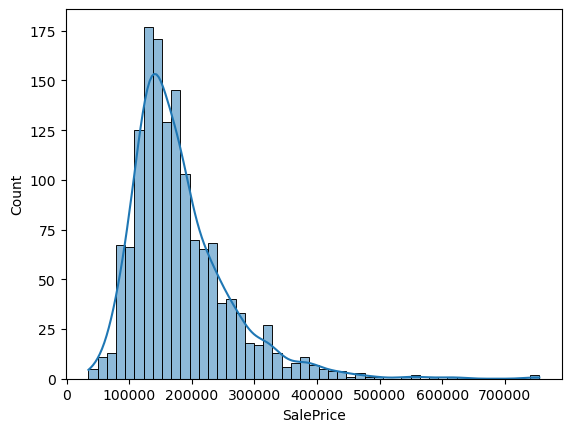

Skewness:  1.8829
Kurtosis:  6.5363


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

sns.histplot(train[target], kde=True)
plt.show()
print('Skewness: ', f'{train[target].skew():.4f}')
print('Kurtosis: ', f'{train[target].kurt():.4f}')

Here we use log1p (log(1+x)) to transform the target.

For this column, using log and log1p yield similar results.

But for those columns with some zero values, log1p is better. (log(0) is undefined)

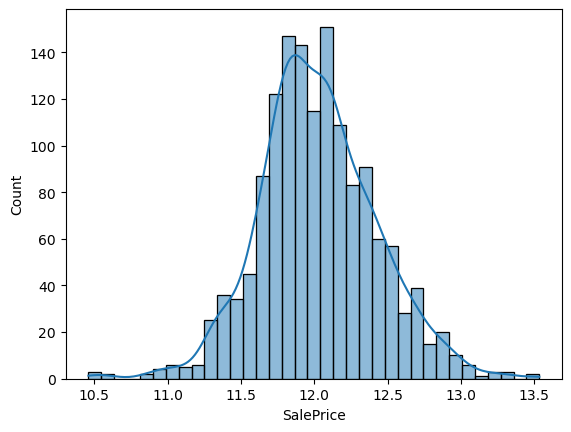

Skewness:  0.1213
Kurtosis:  0.8095


In [3]:
# Convert target column to log1p, for lower skewness and better performance
train_target = np.log1p(train_target)
train.drop(target, axis=1, inplace=True)
sns.histplot(train_target, kde=True)
plt.show()
print('Skewness: ', f'{train_target.skew():.4f}')
print('Kurtosis: ', f'{train_target.kurt():.4f}')

The target is more normally distributed after log1p.

Now we move to the features.

We check the missing values, and fill them with the appropriate values.

# Filling missing values and handle the categorical features

Here are some options for handling categorical features:

- Drop the categorical features (not recommended)
- Get dummy variables
- Convert them to ordinal or numeric values

In [4]:
# Some options for later use
cat_handle = 1
num_handle = 1
ord_handle = 1

if cat_handle == 1:
    cat_handle = 'FillWithMedian' # Convert each category to its median of SalePrice, then min-max scale
else:
    cat_handle = 'GetDummies' # Get dummies for each category
if num_handle == 1:
    num_handle = 'log1p'
else:
    num_handle = 'BoxCox'
if ord_handle == 1:
    ord_handle = 'ConvertToNum' # Convert each ordinal category to its median of SalePrice
else:
    ord_handle = 'GetDummies'# Get dummies for each ordinal category

Combine train and test data to make sure the same columns are treated in the same way.

In [5]:
# Combine train and test data into one dataframe
combined = pd.concat([train, test], axis=0)

Some features are recorded as numeric values, but they are actually categorical features. (MoSold and MSSubClass)

In [6]:
# Convert some numerical features to categorical features
combined['MSSubClass'] = combined['MSSubClass'].astype('object')
combined['MoSold'] = combined['MoSold'].astype('object')

For those ordinal features, we can convert them to numeric values.

But it's a bit tricky to decide the order of the values.

Some columns look like ordinal features, but the violin plot shows that they are not.

- For those columns whose variables are related to the quality, we can convert them to numeric values.

- But for those columns which look like ordinal features, but the violin plot shows that they are not, we can convert them to their median of SalePrice.

In [7]:
# Convert ordinal features to numerical features
# First, convert those features related to the quality of something
col_ord = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
            'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
for col in col_ord:
    combined[col] = combined[col].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0})

# Then, handle the rest of ordinal features, with different methods
if ord_handle == 'ConvertToNum':
    combined['BsmtExposure'] = combined['BsmtExposure'].map({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, np.nan: 0})
    combined['BsmtFinType1'] = combined['BsmtFinType1'].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, np.nan: 0})
    combined['BsmtFinType2'] = combined['BsmtFinType2'].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, np.nan: 0})
    combined['Functional'] = combined['Functional'].map({'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1})
    combined['GarageFinish'] = combined['GarageFinish'].map({'Fin': 3, 'RFn': 2, 'Unf': 1, np.nan: 0})
    combined['Fence'] = combined['Fence'].map({'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, np.nan: 0})
elif ord_handle == 'GetDummies':
    for i in ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'GarageFinish', 'Fence']:
        combined[i] = combined[i].fillna('None')
else:
    pass

Some houses lack the GarageYrBlt feature, which means they don't have a garage.

We can fill the missing values with YearBuilt.

In [8]:
# Fill GarageYrBlt with YearBuilt
combined['GarageYrBlt'].fillna(combined['YearBuilt'], inplace=True)

And some other missing values can be filled with 'None' or 0.

In [9]:
# Fill missing values with 'None' or 0 for some features
col_cat_fillNA = ['Alley', 'GarageType', 'MiscFeature', 'MasVnrType']
for col in col_cat_fillNA:
    combined[col].fillna('None', inplace=True)
col_num_fillNA = ['MiscFeature', 'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath',
                    'Functional', 'GarageArea', 'GarageCars', 'TotalBsmtSF',
                    'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1']
for col in col_num_fillNA:
    combined[col].fillna(0, inplace=True)

Some features should not be 0 or None, so we can fill them with the median or mode value of the same group.

In [10]:
# Fill LotFrontage with median value of the neighborhood
combined['LotFrontage'] = combined.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# Fill MSZoning with mode value of MSSubClass
combined['MSZoning'] = combined.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

# Fill other categorical features with mode value of the neighborhood and OverallQual
col_cat_fillNA = ['Electrical', 'Utilities', 'Exterior1st', 'Exterior2nd', 'SaleType', 'KitchenQual']
for col in col_cat_fillNA:
    combined[col] = combined.groupby(['Neighborhood', 'OverallQual'])[col].transform(lambda x: x.fillna(x.mode()[0]))

Add some new features.

In [11]:
# Add some features
p1 = 1
p2 = 1
p3 = 1
combined['TotalSF1'] = combined['TotalBsmtSF'] * p1 + combined['1stFlrSF'] * p2 + combined['2ndFlrSF'] * p3
combined['HasWoodDeck'] = (combined['WoodDeckSF'] == 0) * 1
combined['HasOpenPorch'] = (combined['OpenPorchSF'] == 0) * 1
combined['HasEnclosedPorch'] = (combined['EnclosedPorch'] == 0) * 1
combined['Has3SsnPorch'] = (combined['3SsnPorch'] == 0) * 1
combined['HasScreenPorch'] = (combined['ScreenPorch'] == 0) * 1
combined['TotalBathrooms'] = combined['FullBath'] + combined['HalfBath'] * 0.5 + combined['BsmtFullBath'] + combined['BsmtHalfBath'] * 0.5
combined['TotalPorchSF'] = combined['OpenPorchSF'] + combined['3SsnPorch'] + combined['EnclosedPorch'] + combined['ScreenPorch'] + combined['WoodDeckSF']

There is a 2207 in the GarageYrBlt column, which is definitely not a valid year.

We can replace it with 2007.

In [12]:
# Correct some features
combined.loc[combined['GarageYrBlt'] == 2207, 'GarageYrBlt'] = 2007

In [13]:
# Add a new feature, RemodAfterBuilt, and clip to 0
combined['RemodAfterBuilt'] = combined['YearRemodAdd'] - combined['YearBuilt']
combined['RemodAfterBuilt'] = combined['RemodAfterBuilt'].clip(lower=0)

All the features related to the year have large numbers, which should be scaled.

In [14]:
# Convert all features related to year to age
for i in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']:
    combined[i] = combined[i] - combined[i].min()

In [15]:
# Check the missing values in train and test set
print(combined.isnull().sum()[combined.isnull().sum() > 0].sort_values(ascending=False))

Series([], dtype: int64)


Now we have eliminated all the missing values!

In [16]:
# Get the train set back
train = combined.iloc[:-len(test_id), :]
test = combined.iloc[-len(test_id):, :]
train[target] = train_target

Check if dropping any outliers helps. (Here it helps in cross validation of the training data, but not in the test data)

In [17]:
# Scatter the target with TotalSF1
#'''
fig = go.Figure()
fig.add_trace(go.Scatter(x=train['TotalSF1'], y=train[target], mode='markers',
                            hovertemplate='TotalSF1: %{x}<br>Target: %{y}<extra></extra>'))
fig.update_layout(title='Scatter of TotalSF1 and Target', xaxis_title='TotalSF1', yaxis_title='Target')
fig.show()
#'''
''

''

We can see that there are two outliers in the training data, and their TotalSF1 is larger than 7500.

In [18]:
# Drop the outliers, whose TotalSF1 is larger than 7500
# Those two outliers are very obvious in the scatter plot
# train = train[train['TotalSF1'] < 7500]

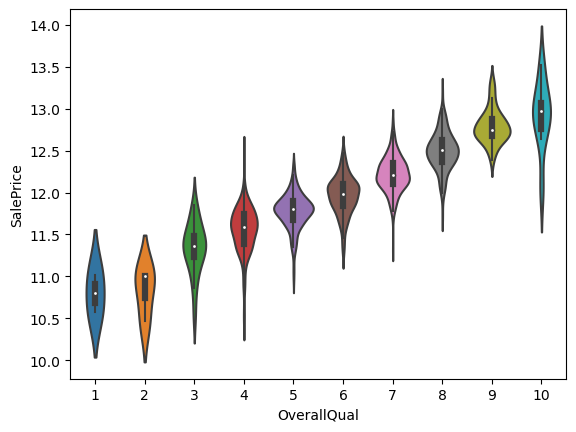

In [19]:
# Plot the violin plot of OverallQual and target
sns.violinplot(x=train['OverallQual'], y=train[target])
plt.show()

We can see that the OverallQual 4 distributes more widely than the others.

In [20]:
# Drop the outliers, which meet the following conditions:
# 1. OverallQual is 4
# 2. Target is over 12.4 or less than 10.5
# outliers = train[(train['OverallQual'] == 4) & ((train[target] > 12.4) | (train[target] < 10.5))].index
# outliers = train[(train['OverallQual'] == 4) & ((train[target] > 12.4))].index
# train.drop(outliers, axis=0, inplace=True)
# sns.violinplot(x=train['OverallQual'], y=train[target])
# plt.show()

In [21]:
# Get the combined set back
train.drop(target, axis=1, inplace=True)
combined = pd.concat([train, test], axis=0)

In [22]:
# Check the missing values in the combined set
print(combined.isnull().sum()[combined.isnull().sum() > 0].sort_values(ascending=False))

Series([], dtype: int64)


Now, we scale the numberical features.

In [23]:
# Print the description of numerical features, sort by max value
print(combined.describe().T[['mean', 'std', 'min', 'max']].sort_values(by='max', ascending=False))

                          mean          std     min       max
LotArea           10168.114080  7886.996359  1300.0  215245.0
MiscVal              50.825968   567.402211     0.0   17000.0
TotalSF1           2547.482700   805.120840   334.0   11752.0
TotalBsmtSF        1051.417266   441.120498     0.0    6110.0
BsmtFinSF1          441.272011   455.606014     0.0    5644.0
GrLivArea          1500.759849   506.051045   334.0    5642.0
1stFlrSF           1159.581706   392.362079   334.0    5095.0
BsmtUnfSF           560.579993   439.590889     0.0    2336.0
2ndFlrSF            336.483727   428.701456     0.0    2065.0
MasVnrArea          101.396026   178.854579     0.0    1600.0
BsmtFinSF2           49.565262   169.179104     0.0    1526.0
GarageArea          472.712573   215.535686     0.0    1488.0
WoodDeckSF           93.709832   126.526589     0.0    1424.0
TotalPorchSF        182.959575   160.021404     0.0    1424.0
LowQualFinSF          4.694416    46.396825     0.0    1064.0
Enclosed

We can see those whose max is over 300 are all numerical features related to the area or length.

And whose max is between 50 and 300 are related to the year.

Whose max is less than 50 are related to the quality, or number of rooms, or from categorical features.

In [24]:
# We see that those features with max value over 300 are all related to area or length
# Here we use log1p or boxcox to handle them
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Select features with max value over 300
col_num_h = combined.describe().T[combined.describe().T['max'] > 300].index.to_list()
col_num_m = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', 'RemodAfterBuilt']
col_num_l = combined.describe().T[combined.describe().T['max'] <= 50].index.to_list()

if num_handle == 'log1p':
    for col in col_num_h:
        combined[col] = np.log1p(combined[col])
    # MinMaxScale those features
    scaler = MinMaxScaler()
    combined[col_num_h] = scaler.fit_transform(combined[col_num_h])
elif num_handle == 'BoxCox':
    for col in col_num_h:
        # Check if the skewness is over 2
        if combined[col].skew() > 2:
            lam = boxcox_normmax(combined[col] + 1)
            combined[col] = boxcox1p(combined[col], lam)
        else:
            combined[col] = combined[col]
    # StandardScale those features
    scaler = StandardScaler()
    combined[col_num_h] = scaler.fit_transform(combined[col_num_h])
    scaler = MinMaxScaler()
    combined[col_num_h] = scaler.fit_transform(combined[col_num_h])
else:
    pass

In [25]:
# Check the distribution of col_num_h
print(combined[col_num_h].describe().T[['mean', 'std', 'min', 'max']].sort_values(by='std', ascending=False))
print('*' * 64)
# Check the skewness of col_num_h
print(combined[col_num_h].skew().sort_values(ascending=False))

                   mean       std  min  max
2ndFlrSF       0.370686  0.429302  0.0  1.0
WoodDeckSF     0.337330  0.356976  0.0  1.0
MasVnrArea     0.281801  0.355215  0.0  1.0
BsmtFinSF1     0.489083  0.345179  0.0  1.0
OpenPorchSF    0.352914  0.325872  0.0  1.0
TotalPorchSF   0.590475  0.280657  0.0  1.0
BsmtFinSF2     0.092889  0.256243  0.0  1.0
EnclosedPorch  0.109445  0.256029  0.0  1.0
BsmtUnfSF      0.725215  0.241001  0.0  1.0
ScreenPorch    0.070970  0.229607  0.0  1.0
GarageArea     0.795606  0.197054  0.0  1.0
TotalBsmtSF    0.772075  0.135637  0.0  1.0
MiscVal        0.024101  0.127318  0.0  1.0
LotFrontage    0.419719  0.123812  0.0  1.0
1stFlrSF       0.437186  0.118530  0.0  1.0
GrLivArea      0.512518  0.114995  0.0  1.0
LotArea        0.376622  0.099808  0.0  1.0
LowQualFinSF   0.011061  0.094606  0.0  1.0
3SsnPorch      0.010621  0.094199  0.0  1.0
TotalSF1       0.556911  0.088062  0.0  1.0
PoolArea       0.004092  0.061363  0.0  1.0
********************************

In [26]:
# Min-max scale col_num_m and col_num_l
scaler = MinMaxScaler()
combined[col_num_m] = scaler.fit_transform(combined[col_num_m])
combined[col_num_l] = scaler.fit_transform(combined[col_num_l])
print(combined.describe().T[['mean', 'std', 'min', 'max']].sort_values(by='std', ascending=False))

                      mean       std  min  max
HasWoodDeck       0.521754  0.499612  0.0  1.0
HasOpenPorch      0.444673  0.497015  0.0  1.0
2ndFlrSF          0.370686  0.429302  0.0  1.0
HasEnclosedPorch  0.842754  0.364095  0.0  1.0
FireplaceQu       0.353614  0.361324  0.0  1.0
WoodDeckSF        0.337330  0.356976  0.0  1.0
MasVnrArea        0.281801  0.355215  0.0  1.0
BsmtFinType1      0.590271  0.352309  0.0  1.0
YearRemodAdd      0.571075  0.348239  0.0  1.0
BsmtFinSF1        0.489083  0.345179  0.0  1.0
YrSold            0.448184  0.328741  0.0  1.0
OpenPorchSF       0.352914  0.325872  0.0  1.0
Fence             0.145170  0.304353  0.0  1.0
GarageFinish      0.572000  0.299109  0.0  1.0
HasScreenPorch    0.912299  0.282908  0.0  1.0
TotalPorchSF      0.590475  0.280657  0.0  1.0
BsmtExposure      0.405961  0.267506  0.0  1.0
BsmtFinSF2        0.092889  0.256243  0.0  1.0
EnclosedPorch     0.109445  0.256029  0.0  1.0
HalfBath          0.190134  0.251436  0.0  1.0
BsmtUnfSF    

Now we sclaed all the numerical features to [0, 1], with a smaller skewness than the original ones.

For categorical features, we convert them to their median of SalePrice, except for those who only have two varibles.

In [27]:
# Handle the categorical features
# Get train data back
col_cat = combined.select_dtypes(include='object').columns.to_list()
if cat_handle == 'FillWithMedian':
    train = combined[:train_id.shape[0]]
    train[target] = train_target
    # Select the categorical features with unique value over 2
    col_cat_h = combined[col_cat].nunique()[combined[col_cat].nunique() > 2].index.to_list()
    for i in col_cat_h:
        # Get the median of each category
        cat_median = train.groupby(i)[target].median().to_dict()
        # Convert the category to median
        combined[i] = combined[i].map(cat_median)
        scaler == MinMaxScaler()
        combined[i] = scaler.fit_transform(combined[i].values.reshape(-1, 1))
    col_cat_l = combined[col_cat].nunique()[combined[col_cat].nunique() <= 2].index.to_list()
    combined = pd.get_dummies(combined, columns=col_cat_l, drop_first=True)
elif cat_handle == 'GetDummies':
    combined = pd.get_dummies(combined, columns=col_cat, drop_first=True)
else:
    pass

In [28]:
# Get the train and test set by the length of the test_id
test = combined.iloc[-len(test_id):, :]
train = combined.iloc[:-len(test_id), :]
train[target] = train_target

In [29]:
# Check the missing values in the train and test set
print(train.isnull().sum()[train.isnull().sum() > 0].sort_values(ascending=False))
print(test.isnull().sum()[test.isnull().sum() > 0].sort_values(ascending=False))

Series([], dtype: int64)
MSSubClass    1
dtype: int64


In [30]:
# Fill MSSubClass with the mode of the same neighborhood
test['MSSubClass'] = test.groupby('Neighborhood')['MSSubClass'].transform(lambda x: x.fillna(x.mode()[0]))

# Building and tuning the model

We have done the feature engineering, now we can build the model.

Here we use LazyRegressor to test all the models in sklearn.

And we tune the hyperparameters with cross validation of kfolds=10. (It takes a long time to run but it's worth it)

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train.drop(target, axis=1), train[target], test_size=0.25, random_state=random_seed)
# Only works for lazypredict, not used in cross validation

In [32]:
'''
from lazypredict import Supervised
from lazypredict.Supervised import LazyRegressor

reg = LazyRegressor(verbose=1,
                        ignore_warnings=True,
                        custom_metric=None,
                        predictions=False,
                        random_state=random_seed,
                        # cv=5,
                        regressors='all')

models, predictions = reg.fit(X_train, X_test, y_train, y_test)
models.sort_values(by='RMSE', ascending=True, inplace=True)
print(models[:10])
'''
''

''

In [33]:
'''
                           Adjusted R-Squared  R-Squared   RMSE  Time Taken
Model                                                                      
GradientBoostingRegressor              0.8906     0.9171 0.1179      0.6200
HuberRegressor                         0.8901     0.9167 0.1182      0.0690
ExtraTreesRegressor                    0.8869     0.9142 0.1199      1.0740
LassoLarsCV                            0.8830     0.9113 0.1219      0.1030
LassoCV                                0.8830     0.9113 0.1219      0.1620
ElasticNetCV                           0.8828     0.9111 0.1220      0.2040
LarsCV                                 0.8823     0.9107 0.1223      0.0900
LassoLarsIC                            0.8793     0.9085 0.1238      0.0370
LinearSVR                              0.8784     0.9078 0.1243      0.1900
PoissonRegressor                       0.8757     0.9058 0.1257      0.0490
'''
''

''

In [34]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=10, shuffle=True, random_state=random_seed)

def rmsle_cv(model):
    # model.fit(train.drop(target, axis=1), train[target])
    rmse = np.sqrt(-cross_val_score(model, train.drop(target, axis=1), train[target], cv=kf, scoring='neg_mean_squared_error').mean())
    return rmse

In [35]:
# Using GradientBoostingRegressor, ExtraTreesRegressor, LassoLarsCV, XGBRegressor, LGBMRegressor, ElasticNetCV, SVR, LinearSVR, Ridge and HistGradientBoostingRegressor
# Import the models
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LassoLarsCV, ElasticNetCV, Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import LinearSVR, SVR

In [36]:
'''
# Get parameters for each model
pa1 = reg.models['GradientBoostingRegressor'].steps[1][1].get_params()
pa2 = reg.models['ExtraTreesRegressor'].steps[1][1].get_params()
pa3 = reg.models['LassoLarsCV'].steps[1][1].get_params()
pa4 = reg.models['XGBRegressor'].steps[1][1].get_params()
pa5 = reg.models['LGBMRegressor'].steps[1][1].get_params()
pa6 = reg.models['ElasticNetCV'].steps[1][1].get_params()
pa7 = reg.models['LinearSVR'].steps[1][1].get_params()
pa8 = reg.models['SVR'].steps[1][1].get_params()
pa9 = reg.models['Ridge'].steps[1][1].get_params()
pa10 = reg.models['HistGradientBoostingRegressor'].steps[1][1].get_params()
print(pa1)
print(pa2)
print(pa3)
print(pa4)
print(pa5)
print(pa6)
print(pa7)
print(pa8)
print(pa9)
print(pa10)
'''
''

''

Searching for the best hyperparameters for each model. (The result from lazypredict is not the best)

Here we use a manual way to tune the hyperparameters.

The process comes from Microsoft's online course:

https://learn.microsoft.com/en-us/training/modules/machine-learning-architectures-and-hyperparameters/7-exercise-hyperparameters-tuning

Here I skip the part of tuning the hyperparameters, just show the results.

In [37]:
# GradientBoostingRegressor
'''
# variables = [40, 80, 160, 320, 640]
# variables = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1]
# variables = [1, 2, 4, 8 ,16, 32]
# variables = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# variables = [1, 2, 3, 4, 5, 6]
# Train our models and report their performance
scores = []

for i in variables:
    print("Preparing a model with i = {}".format(i))

    # Prepare the model
    gb = GradientBoostingRegressor(n_estimators=1280,
                                    learning_rate=0.03,
                                    max_depth=4,
                                    max_features=8,
                                    min_samples_leaf=1,
                                    min_samples_split=16,
                                    random_state=1,
                                    verbose=False)
    
    # Train and test the result
    scores.append(rmsle_cv(gb))

# Plot results
fig = go.Figure()
fig.add_trace(go.Scatter(x=variables, y=scores, mode='lines+markers', name='Test',
                        hovertemplate='i: %{x}<br>RMSE: %{y:.4f}<extra></extra>'))
fig.update_layout(title='RMSE vs. i', xaxis_title='i', yaxis_title='RMSE', xaxis_type='log')
fig.show()
'''
''

''

In [38]:
gb = GradientBoostingRegressor(n_estimators=1000,
                                learning_rate=0.03,
                                max_depth=4,
                                max_features=8,
                                min_samples_leaf=1,
                                min_samples_split=16,
                                random_state=1,
                                verbose=False)
# RMSLE_CV = 0.110419
# print('GradientBoostingRegressor: {:.6f}'.format(rmsle_cv(gb)))

List the features and their importance, and see if dropping any of them helps. (Here it doesn't help)

In [39]:
# List the features by their importance
pd.set_option('display.max_rows', None)
gb.fit(train.drop(target, axis=1), train[target])
feature_importance = pd.DataFrame({'feature': train.drop(target, axis=1).columns, 'importance': gb.feature_importances_})
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
print(feature_importance)

             feature  importance
14       OverallQual    0.180577
76          TotalSF1    0.168146
42         GrLivArea    0.061356
57        GarageCars    0.042328
24         ExterQual    0.038559
9       Neighborhood    0.037139
49       KitchenQual    0.028473
17      YearRemodAdd    0.027780
53       FireplaceQu    0.025265
58        GarageArea    0.022370
39          1stFlrSF    0.022010
55       GarageYrBlt    0.021223
31        BsmtFinSF1    0.020630
35       TotalBsmtSF    0.020294
82    TotalBathrooms    0.020068
3            LotArea    0.018813
27          BsmtQual    0.018382
26        Foundation    0.017146
56      GarageFinish    0.017141
45          FullBath    0.016794
16         YearBuilt    0.015830
15       OverallCond    0.013142
40          2ndFlrSF    0.012328
0         MSSubClass    0.011430
54        GarageType    0.011247
1           MSZoning    0.009726
87      CentralAir_Y    0.009435
50      TotRmsAbvGrd    0.007104
60        GarageCond    0.006738
30      Bs

In [40]:
'''
variables = [1e-2, 3e-3, 1e-3, 3e-4, 1e-4, 3e-5, 1e-5]
scores = []
for i in variables:
    # Drop features with importance less than i
    features = feature_importance[feature_importance['importance'] > i]['feature'].to_list()
    train_drop = train.copy()
    train_drop = train_drop[features]
    gb = GradientBoostingRegressor(n_estimators=1000,
                                    learning_rate=0.03,
                                    max_depth=4,
                                    max_features=8,
                                    min_samples_leaf=1,
                                    min_samples_split=16,
                                    random_state=1,
                                    verbose=False)
    gb.fit(train_drop, train[target])
    rmse_cv = np.sqrt(-cross_val_score(gb, train_drop, train[target], cv=kf, scoring='neg_mean_squared_error').mean())
    scores.append(rmse_cv)

# Plot results
fig = go.Figure()
fig.add_trace(go.Scatter(x=variables, y=scores, mode='lines+markers', name='Test',
                        hovertemplate='i: %{x}<br>RMSE: %{y:.4f}<extra></extra>'))
fig.update_layout(title='RMSE vs. i', xaxis_title='i', yaxis_title='RMSE', xaxis_type='log')
fig.show()
'''
# All features are useful
''

''

In [41]:
# ExtraTreesRegressor
'''
# variables = [40, 80, 160, 320, 640]
# variables = [1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1]
# variables = [2, 4, 8 ,16, 32, 64, 128]
# variables = [0, 1, 2, 3, 4, 5]
# Train our models and report their performance
scores = []

for i in variables:
    print("Preparing a model with i = {}".format(i))

    # Prepare the model
    et = ExtraTreesRegressor(n_estimators=320,
                                max_depth=16,
                                min_samples_leaf=1,
                                min_samples_split=2,
                                max_features=64,
                                random_state=i,
                                n_jobs=-1,
                                verbose=False)

    # Train and test the result
    scores.append(rmsle_cv(et))

# Plot results
fig = go.Figure()
fig.add_trace(go.Scatter(x=variables, y=scores, mode='lines+markers', name='Test',
                        hovertemplate='i: %{x}<br>RMSE: %{y:.4f}<extra></extra>'))
fig.update_layout(title='RMSE vs. i', xaxis_title='i', yaxis_title='RMSE')
fig.show()
'''
''

''

In [42]:
et = ExtraTreesRegressor(n_estimators=320,
                            max_depth=16,
                            min_samples_leaf=1,
                            min_samples_split=2,
                            max_features=64,
                            max_leaf_nodes=None,
                            random_state=3,
                            n_jobs=-1,
                            verbose=False)
# RMSLE_CV = 0.124925
# print('ExtraTreesRegressor: {:.6f}'.format(rmsle_cv(et)))

In [43]:
# LassoLarsCV
'''
# variables = [40, 80, 160, 320, 640]
# variables = [1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1]
# variables = [1, 2, 4, 8 ,16, 32, 64, 128]
variables = [0, 1, 2, 3, 4, 5]
# Train our models and report their performance
scores = []

for i in variables:
    print("Preparing a model with i = {}".format(i))

    # Prepare the model
    lasso = LassoLarsCV(max_iter=64,
                        cv=kf,
                        max_n_alphas=i,
                        n_jobs=-1)

    # Train and test the result
    scores.append(rmsle_cv(lasso))

# Plot results
fig = go.Figure()
fig.add_trace(go.Scatter(x=variables, y=scores, mode='lines+markers', name='Test',
                        hovertemplate='i: %{x}<br>RMSE: %{y:.4f}<extra></extra>'))
fig.update_layout(title='RMSE vs. i', xaxis_title='i', yaxis_title='RMSE', xaxis_type='log')
fig.show()
'''
''

''

In [44]:
lasso = LassoLarsCV(max_iter=64,
                    cv=kf,
                    max_n_alphas=16,
                    n_jobs=-1)
# RMSLE_CV = 0.115774
# print('LassoLarsCV: {:.6f}'.format(rmsle_cv(lasso)))

In [45]:
# XGBRegressor
'''
# variables = [40, 80, 160, 320, 640]
# variables = [1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1]
# variables = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# variables = [1, 2, 4, 8 ,16, 32, 64, 128]
# variables = [0, 1, 2, 3, 4, 5]
# Train our models and report their performance
scores = []

for i in variables:
    print("Preparing a model with i = {}".format(i))

    # Prepare the model
    xgb = XGBRegressor(n_estimators=1280,
                        learning_rate=0.03,
                        max_depth=4,
                        min_child_weight=1,
                        gamma=0,
                        subsample=0.6,
                        colsample_bytree=0.2,
                        reg_alpha=0.01,
                        reg_lambda=0.01,
                        random_state=i,
                        n_jobs=-1,
                        verbosity=0)

    # Train and test the result
    scores.append(rmsle_cv(xgb))

# Plot results
fig = go.Figure()
fig.add_trace(go.Scatter(x=variables, y=scores, mode='lines+markers', name='Test',
                        hovertemplate='i: %{x}<br>RMSE: %{y:.4f}<extra></extra>'))
fig.update_layout(title='RMSE vs. i', xaxis_title='i', yaxis_title='RMSE')
fig.show()
'''
''

''

In [46]:
xgb = XGBRegressor(n_estimators=1280,
                    learning_rate=0.03,
                    max_depth=4,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.6,
                    colsample_bytree=0.2,
                    reg_alpha=0.01,
                    reg_lambda=0.01,
                    random_state=3,
                    n_jobs=-1,
                    verbosity=0)
# RMSLE_CV = 0.109846
# print('XGBRegressor: {:.6f}'.format(rmsle_cv(xgb)))

In [47]:
# LGBMRegressor
'''
# variables = [40, 80, 160, 320, 640]
# variables = [0, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1]
# variables = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# variables = [1, 2, 4, 8 ,16, 32, 64, 128]
# variables = [0, 1, 2, 3, 4, 5]
# Train our models and report their performance
scores = []

for i in variables:
    print("Preparing a model with i = {}".format(i))

    # Prepare the model
    lgb = LGBMRegressor(n_estimators=640,
                        learning_rate=0.03,
                        max_depth=4,
                        min_child_weight=8,
                        colsample_bytree=0.3,
                        reg_alpha=0.1,
                        reg_lambda=0.01,
                        random_state=i,
                        n_jobs=-1,
                        verbosity=-1)

    # Train and test the result
    scores.append(rmsle_cv(lgb))

# Plot results
fig = go.Figure()
fig.add_trace(go.Scatter(x=variables, y=scores, mode='lines+markers', name='Test',
                        hovertemplate='i: %{x}<br>RMSE: %{y:.4f}<extra></extra>'))
fig.update_layout(title='RMSE vs. i', xaxis_title='i', yaxis_title='RMSE')
fig.show()
'''
''

''

In [48]:
lgb = LGBMRegressor(n_estimators=640,
                    learning_rate=0.03,
                    max_depth=4,
                    min_child_weight=8,
                    colsample_bytree=0.3,
                    reg_alpha=0.1,
                    reg_lambda=0.01,
                    random_state=5,
                    n_jobs=-1,
                    verbosity=-1)
# RMSLE_CV = 0.112805
# print('LGBMRegressor: {:.6f}'.format(rmsle_cv(lgb)))

In [49]:
# ElasticNetCV
'''
# variables = [40, 80, 160, 320, 640]
# variables = [1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1]
# variables = [1, 2, 4, 8 ,16, 32, 64, 128]
# Train our models and report their performance
scores = []

for i in variables:
    print("Preparing a model with i = {}".format(i))

    # Prepare the model
    en = ElasticNetCV(max_iter=160,
                        eps=0.0003,
                        cv=kf,
                        l1_ratio=1,
                        n_alphas=40,
                        n_jobs=-1)

    # Train and test the result
    scores.append(rmsle_cv(en))

# Plot results
fig = go.Figure()
fig.add_trace(go.Scatter(x=variables, y=scores, mode='lines+markers', name='Test',
                        hovertemplate='i: %{x}<br>RMSE: %{y:.4f}<extra></extra>'))
fig.update_layout(title='RMSE vs. i', xaxis_title='i', yaxis_title='RMSE', xaxis_type='log')
fig.show()
'''
''

''

In [50]:
en = ElasticNetCV(max_iter=160,
                    eps=0.0003,
                    cv=kf,
                    l1_ratio=1,
                    n_alphas=40,
                    n_jobs=-1)
# RMSLE_CV = 0.114221
# print('ElasticNetCV: {:.6f}'.format(rmsle_cv(en)))

In [51]:
# LinearSVR
'''
# variables = [40, 80, 160, 320, 640]
# variables = [1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1]
# variables = [1, 2, 4, 8 ,16, 32, 64, 128]
# variables = [0, 1, 2, 3, 4, 5]
# Train our models and report their performance
scores = []

for i in variables:
    print("Preparing a model with i = {}".format(i))

    # Prepare the model
    lsvr = LinearSVR(max_iter=320,
                    tol=0.01,
                    epsilon=0.001,
                    C=16,
                    random_state=i,
                    verbose=False)

    # Train and test the result
    scores.append(rmsle_cv(lsvr))

# Plot results
fig = go.Figure()
fig.add_trace(go.Scatter(x=variables, y=scores, mode='lines+markers', name='Test',
                        hovertemplate='i: %{x}<br>RMSE: %{y:.4f}<extra></extra>'))
fig.update_layout(title='RMSE vs. i', xaxis_title='i', yaxis_title='RMSE')
fig.show()
'''
''

''

In [52]:
lsvr = LinearSVR(max_iter=320,
                tol=0.01,
                epsilon=0.001,
                C=16,
                random_state=1,
                verbose=False)
# RMSLE_CV = 0.160382
# print('LinearSVR: {:.6f}'.format(rmsle_cv(lsvr)))

In [53]:
# SVR
'''
# variables = [40, 80, 160, 320, 640]
# variables = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1]
# variables = [1, 2, 4, 8 ,16, 32, 64, 128]
variables = [0, 1, 2, 3, 4, 5]
# Train our models and report their performance
scores = []

for i in variables:
    print("Preparing a model with i = {}".format(i))

    # Prepare the model
    svr = SVR(kernel='rbf',
                gamma=0.003,
                C=16,
                epsilon=0.01,
                max_iter=1280,
                tol=0.001,
                verbose=False)

    # Train and test the result
    scores.append(rmsle_cv(svr))

# Plot results
fig = go.Figure()
fig.add_trace(go.Scatter(x=variables, y=scores, mode='lines+markers', name='Test',
                        hovertemplate='i: %{x}<br>RMSE: %{y:.4f}<extra></extra>'))
fig.update_layout(title='RMSE vs. i', xaxis_title='i', yaxis_title='RMSE', xaxis_type='log')
fig.show()
'''
''

''

In [54]:
svr = SVR(kernel='rbf',
            gamma=0.003,
            C=16,
            epsilon=0.01,
            max_iter=1280,
            tol=0.001,
            verbose=False)
# RMSLE_CV = 0.114841
# print('SVR: {:.6f}'.format(rmsle_cv(svr)))

In [55]:
# Ridge
'''
# variables = [40, 80, 160, 320, 640]
# variables = [1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1]
# variables = [1, 2, 4, 8 ,16, 32, 64, 128]
# variables = [0, 1, 2, 3, 4, 5]
# Train our models and report their performance
scores = []

for i in variables:
    print("Preparing a model with i = {}".format(i))

    # Prepare the model
    ridge = Ridge(alpha=1,
                    max_iter=40,
                    random_state=1)

    # Train and test the result
    scores.append(rmsle_cv(ridge))

# Plot results
fig = go.Figure()
fig.add_trace(go.Scatter(x=variables, y=scores, mode='lines+markers', name='Test',
                        hovertemplate='i: %{x}<br>RMSE: %{y:.4f}<extra></extra>'))
fig.update_layout(title='RMSE vs. i', xaxis_title='i', yaxis_title='RMSE')
fig.show()
'''
''

''

In [56]:
ridge = Ridge(alpha=1,
                max_iter=40,
                random_state=1)
# RMSLE_CV = 0.114988
# print('Ridge: {:.6f}'.format(rmsle_cv(ridge)))

In [57]:
# HistGradientBoostingRegressor
'''
# variables = [40, 80, 160, 320, 640]
# variables = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1]
# variables = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# variables = [2, 4, 8 ,16, 32, 64, 128]
# variables = [0, 1, 2, 3, 4, 5]
# Train our models and report their performance
scores = []

for i in variables:
    print("Preparing a model with i = {}".format(i))

    # Prepare the model
    hgb = HistGradientBoostingRegressor(max_iter=640,
                                        learning_rate=0.03,
                                        max_depth=4,
                                        min_samples_leaf=1,
                                        max_leaf_nodes=16,
                                        max_bins=128,
                                        random_state=1,
                                        verbose=False)

    # Train and test the result
    scores.append(rmsle_cv(hgb))

# Plot results
fig = go.Figure()
fig.add_trace(go.Scatter(x=variables, y=scores, mode='lines+markers', name='Test',
                        hovertemplate='i: %{x}<br>RMSE: %{y:.4f}<extra></extra>'))
fig.update_layout(title='RMSE vs. i', xaxis_title='i', yaxis_title='RMSE', xaxis_type='log')
fig.show()
'''
''

''

In [58]:
hgb = HistGradientBoostingRegressor(max_iter=640,
                                    learning_rate=0.03,
                                    max_depth=4,
                                    min_samples_leaf=1,
                                    max_leaf_nodes=16,
                                    max_bins=128,
                                    random_state=1,
                                    verbose=False)
# RMSLE_CV = 0.118004
# print('HistGradientBoostingRegressor: {:.6f}'.format(rmsle_cv(hgb)))

In [59]:
# Scores of all models, sorted by RMSLE_CV
'''
XGBRegressor: 0.109846
GradientBoostingRegressor: 0.110419
LGBMRegressor: 0.112805
ElasticNetCV: 0.114221
SVR: 0.114841
Ridge: 0.114988
LassoLarsCV: 0.115774
HistGradientBoostingRegressor: 0.118004
ExtraTreesRegressor: 0.124925
LinearSVR: 0.160382
'''
''

''

We have some models with different cv scores, and they have different pros and cons.

A way to avoid overfitting is to use the average of the predictions from different models.

Here, a model highly tuned for cv shows a high score in the training data, but a low score in the test data.

However, a model without much tuning shows a low score in the training data, but a high score in the test data.

In [60]:
# Using XGBRegressor, GradientBoostingRegressor and LGBMRegressor to build an ensemble model
from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor
'''
for i in np.arange(0, 1.1, 0.1):
    p1 = 0.63 
    p2 = i
    p2r = (1 - p1) * p2
    p3 = (1 - p1) * (1 - p2)
    vot = VotingRegressor(estimators=[('xgb', xgb), ('gb', gb), ('lgb', lgb)], n_jobs=-1, weights=[p1, p2r, p3])
    # Check the RMSLE_CV of the ensemble model
    print(f'p1 = {round(p1, 2)}, p2r = {round(p2r, 2)}, p3 = {round(p3, 2)}, RMSLE_CV = {round(rmsle_cv(vot), 6)}')
'''
''

''

In [61]:
# vot = VotingRegressor(estimators=[('xgb', xgb), ('gb', gb), ('lgb', lgb)], n_jobs=-1, weights=[0.55, 0.27, 0.18]) # This overfits, and results in a worse score in the test set
vot = VotingRegressor(estimators=[('xgb', xgb), ('gb', gb), ('lgb', lgb), ('en', en), ('svr', svr)], n_jobs=-1, weights=[0.2, 0.2, 0.2, 0.2, 0.2]) # This model gets a final score of 0.11700
vot.fit(train.drop(target, axis=1), train[target])
y_pred = vot.predict(test)
y_pred = np.expm1(y_pred)
# Round to -2, because the target is all rounded to -2
y_pred = np.round(y_pred, -2)
submission = pd.DataFrame({'Id': test_id, target: y_pred})
submission.to_csv('submission_21.csv', index=False)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [62]:
# Check the MAE of the ensemble model
from sklearn.metrics import mean_absolute_error
print(f'MAE = {mean_absolute_error(y_test, vot.predict(X_test)):.4f}')
print(f'RMSLE_CV = {rmsle_cv(vot):.6f}')

MAE = 0.0498
RMSLE_CV = 0.116035


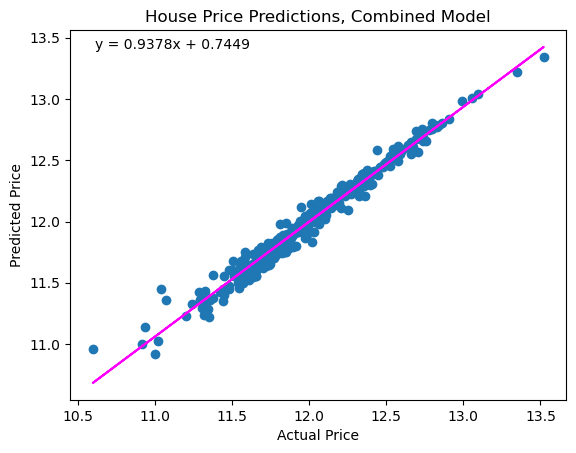

In [63]:
plt.scatter(y_test, vot.predict(X_test))
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('House Price Predictions, Combined Model')
# overlay the regression line
z = np.polyfit(y_test, vot.predict(X_test), 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
# add the trend line equation
trendline_eq = f"y = {round(z[0], 4)}x + {round(z[1], 4)}"
plt.text(0.05, 0.95, trendline_eq, transform=plt.gca().transAxes)
plt.show()